In [1]:
import mat73
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import json
import tqdm
import copy
from matplotlib.ticker import MaxNLocator
np.random.seed(0)

In [2]:
def load_dataframe():
    data_dict = mat73.loadmat('spect_phee2monkey_stft_40X40_2monkey.mat')
    part_data_dict = {key: data_dict[key] for key in data_dict.keys() if key in ['callee', 'caller', 'expname', 'expnameid']}
    df = pd.DataFrame(part_data_dict)
    for name in ['callee', 'caller', 'expname']:
        df[name] = df[name].apply(lambda x: x[0])
    frq = pd.DataFrame(data_dict["frq"].T)
    frq.columns = [f"frq_{i}" for i in range(1, 41)]
    ft = np.abs(pd.DataFrame(data_dict["ft"].T))
    ft.columns = [f"ft_{i}" for i in range(1, 41)]
    df = pd.concat([df, frq, ft], axis=1)
    return df

In [5]:
df_flattend = load_dataframe()

In [18]:
df_flattend = df_flattend.loc[~df_flattend["caller"].isin(["Baloo", "Barak", "Bareket", "Bolt"])]
df_flattend = df_flattend.loc[~df_flattend["callee"].isin(["Baloo", "Barak", "Bareket", "Bolt"])]

remove Chaos as callee

In [19]:
df_no_chaos =  df_flattend.loc[~(df_flattend["callee"] == "Chaos")]
y = df_no_chaos["callee"]
X = df_no_chaos.drop(columns=["caller", "callee", "expname", "expnameid"])

In [30]:
def get_conf_mats_undersampled(X,y, n_reps = 100):
    conf_mats = []
    rfc = RandomForestClassifier(oob_score=True)
    us = RandomUnderSampler()
    for _ in tqdm.tqdm(range(n_reps)):
        X_resampled, y_resampled = us.fit_resample(X,y)
        rfc.fit(X_resampled,y_resampled)
        y_pred = rfc.classes_[np.argmax(rfc.oob_decision_function_,axis=1)]
        cm = confusion_matrix(y_true=y_resampled, y_pred=y_pred, labels=np.unique(y))
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        conf_mats.append(cmn)
    return conf_mats

In [31]:
conf_mats = get_conf_mats_undersampled(X,y)

100%|██████████| 100/100 [53:14<00:00, 31.95s/it]


In [32]:
def display_mean_conf_mat(conf_mats, labels, title):
    mean_conf_mat = np.mean(conf_mats, axis=0)
    fig, ax = plt.subplots(figsize=(15,15))
    f = sns.heatmap(mean_conf_mat, annot=True, fmt=".1%", linewidths=1.0, square=1, cmap='rocket_r')
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)
    return mean_conf_mat

In [33]:
def pred_percent_hist(conf_mats, labels):
    diagonals = []
    for i in range(len(labels)):
        diagonal = []
        for matrix in conf_mats:
            diagonal.append(np.diag(matrix)[i])
        diagonals.append(diagonal)

    plt.figure(figsize=(12,16))
    plt.suptitle("Predictions Percentage Histogram", size=25, y=1.01)
    for i, diagonal in enumerate(diagonals):
        plt.subplot(4, 2, i+1)
        plt.hist(diagonal)
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel(f'Percentage', size=15)
        plt.ylabel('Frequency', size=15)
        plt.title(f'Callee {labels[i]}', size=20)

    plt.tight_layout()
    plt.show()

In [34]:
def pred_percent_violin(conf_mats, labels):
    diagonals = []
    for i in range(len(labels)):
        diagonal = []
        for matrix in conf_mats:
            diagonal.append(np.diag(matrix)[i])
        diagonals.append(diagonal)

    plt.figure(figsize=(12,8))
    plt.suptitle("Predictions Percentage Violin Plot", size=25, y=1.01)
    parts = plt.violinplot(diagonals, showmeans=True, showextrema=False)
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha='right', size=15)
    plt.xlabel('Labels', size=20)
    plt.ylabel('Percentage', size=20)
    plt.title('Distribution of Prediction Percentage for Each Label', size=25)
    plt.tight_layout()
    plt.show()

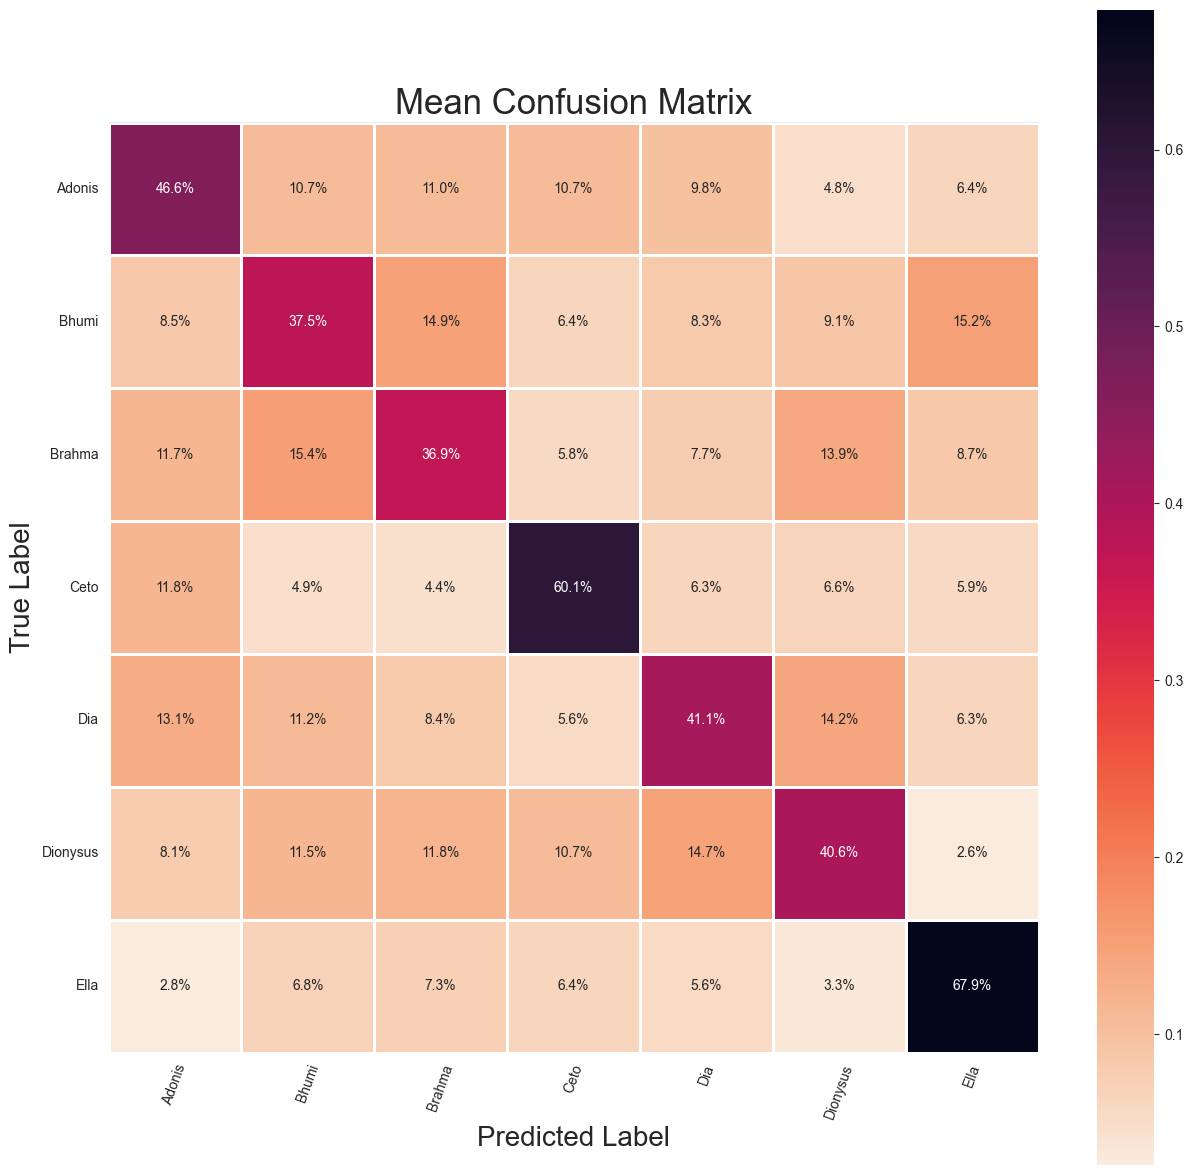

In [35]:
mean_conf_mat = display_mean_conf_mat(conf_mats, np.unique(y), "Mean Confusion Matrix")

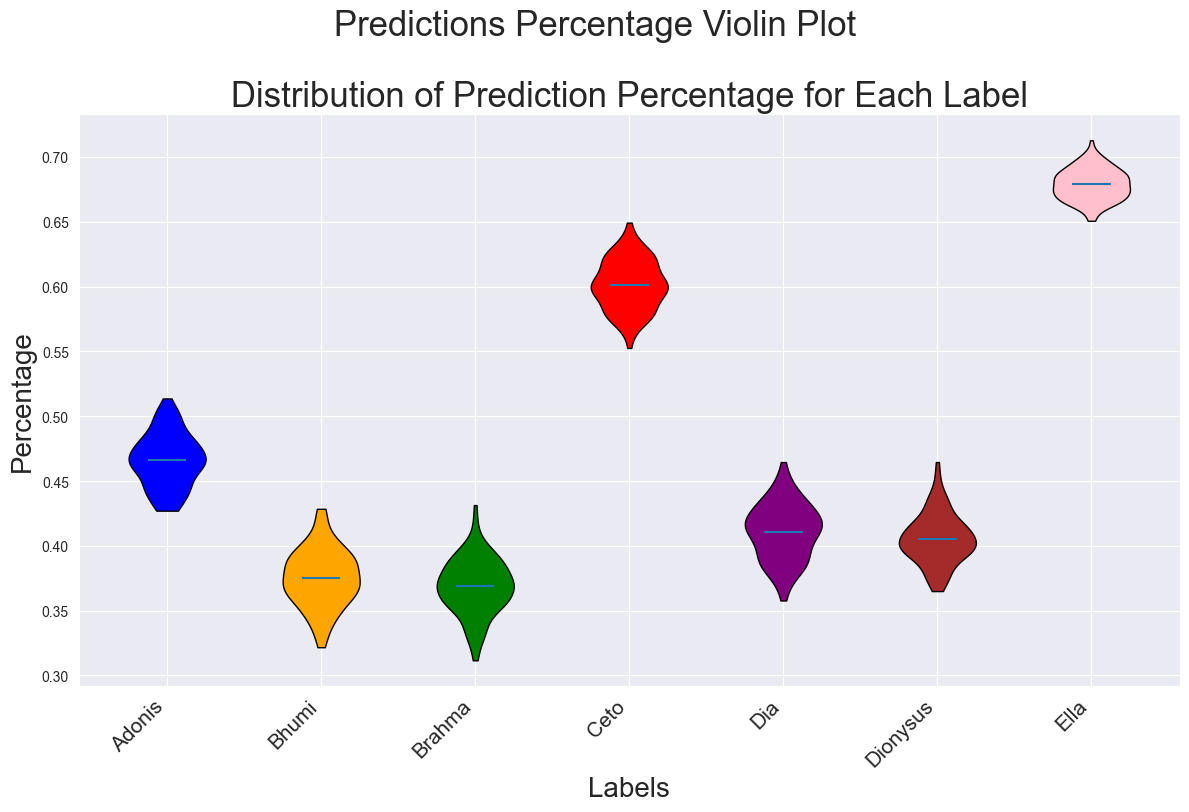

In [36]:
pred_percent_violin(conf_mats, np.unique(y))